In [1]:
from matplotlib import pyplot as plt
import numpy as np
from poisson_numcodecs import Poisson, calibrate
import zarr

### Load example data and estimate `zero_level` and `photon_sensitivity` 

In [2]:
data = np.load('../tests/data/data1.npz')['data']

In [3]:
# for bright images use count_weight_gamma=1
# for photon-starved images with few cells use count_weight_gamma = 0.001
# Otherwise, use the default
calibrator = calibrate.SequentialCalibratePhotons(data)
[photon_sensitivity, dark_signal] = calibrator.get_photon_sensitivity_parameters()  

In [4]:
[photon_sensitivity, dark_signal]

[127.22852025822645, 225.19206948688088]

The slope and x-intercept for the photon transfer curve yield the photon sensitivity and the zero level.

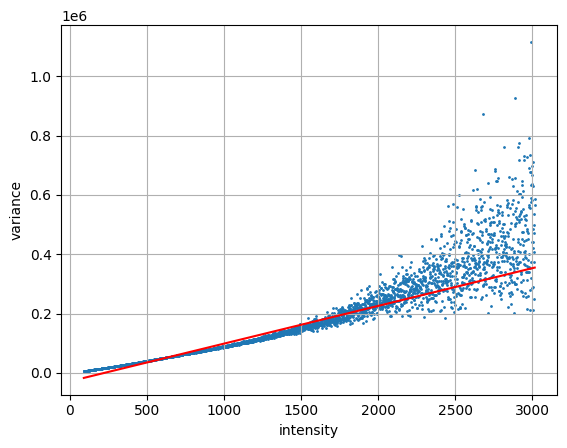

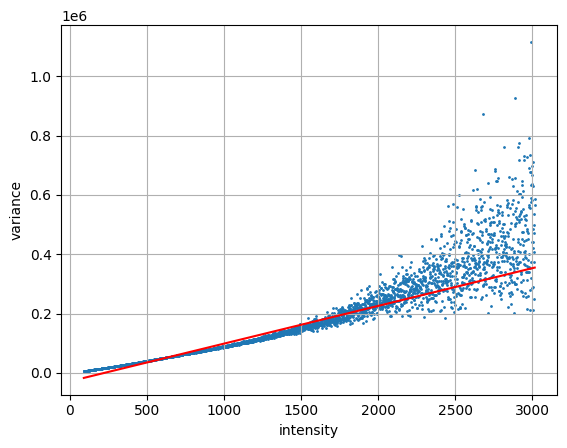

In [5]:
calibrator.plot_poisson_curve()

### Illustrate image compression using numcodecs / zarr

In [6]:
# instantiate Poisson object
poisson_filter = Poisson(photon_sensitivity=photon_sensitivity, dark_signal=dark_signal, beta=0.5, use_lookup=True)

In [7]:

chunk_shape = (1, data.shape[1], data.shape[2])
zarr_array = zarr.open('zarr_array.zarr', mode='w', chunks=chunk_shape, shape=data.shape, dtype=data.dtype, filters=[poisson_filter])
zarr_array[...] = data

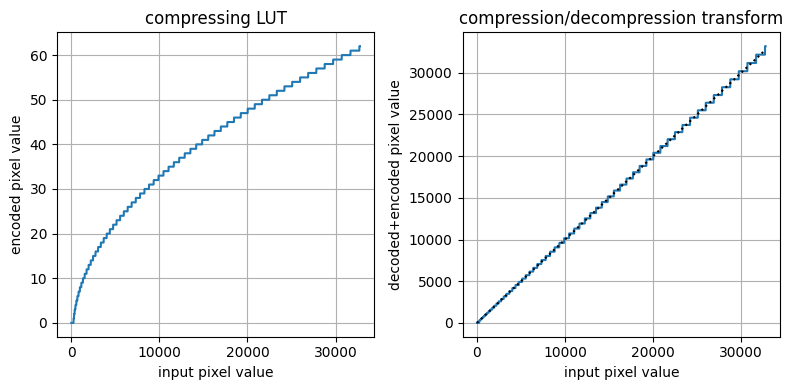

In [8]:
fig, axx = plt.subplots(1, 2, figsize=(8, 4))
axx = iter(axx.flatten())

ax = next(axx)
ax.plot(poisson_filter.forward_table)
ax.set_xlabel('input pixel value')
ax.set_ylabel('encoded pixel value')
ax.grid(True)
ax.set_title('compressing LUT')
plt.tight_layout()

ax = next(axx)
ax.plot(poisson_filter.inverse_table[poisson_filter.forward_table])
ax.plot(np.r_[:poisson_filter.forward_table.size], np.r_[:poisson_filter.forward_table.size], 'k:')
ax.set_xlabel('input pixel value')
ax.set_ylabel('decoded+encoded pixel value')
ax.grid(True)
ax.set_title('compression/decompression transform')
plt.tight_layout()


In [9]:
zarr_array.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(1, 200, 200)"
Order,C
Read-only,False
Filter [0],"Poisson(beta=0.5, dark_signal=225.19206948688088, decoded_dtype='int16', encoded_dtype='uint8', forward_table=array([ 0, 0, 0, ..., 62, 62, 62], dtype=uint8), inverse_table=array([ 0, 255, 318, 397, 491, 602, 728, 871, 1029, 1203, 1393, 1599, 1821, 2059, 2313, 2582, 2868, 3169, 3487, 3820, 4169, 4534, 4915, 5312, 5725, 6153, 6598, 7058, 7535, 8027, 8535, 9059, 9599, 10155, 10727, 11314, 11918, 12537, 13173, 13824, 14491, 15174, 15873, 16588, 17319, 18066, 18828, 19607, 20401, 21212, 22038, 22880, 23738, 24612, 25502, 26408, 27329, 28267, 29220, 30190, 31175, 32176, 33193]), photon_sensitivity=127.22852025822645, use_lookup=True)"
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,10209279 (9.7M)


# RESTART THE KERNEL
Restart the kernel manually to test zarr loading

In [10]:
import matplotlib.pyplot as plt
import zarr
from poisson_numcodecs import Poisson

# you don't need to import poisson_numcodecs but it must be installed

In [11]:
# open zarr
z_reopened = zarr.open('zarr_array.zarr', mode='r')
z_reopened.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(1, 200, 200)"
Order,C
Read-only,True
Filter [0],"Poisson(beta=0.5, dark_signal=225.19206948688088, decoded_dtype='int16', encoded_dtype='uint8', forward_table=array([ 0, 0, 0, ..., 62, 62, 62], dtype=uint8), inverse_table=array([ 0, 255, 318, 397, 491, 602, 728, 871, 1029, 1203, 1393, 1599, 1821, 2059, 2313, 2582, 2868, 3169, 3487, 3820, 4169, 4534, 4915, 5312, 5725, 6153, 6598, 7058, 7535, 8027, 8535, 9059, 9599, 10155, 10727, 11314, 11918, 12537, 13173, 13824, 14491, 15174, 15873, 16588, 17319, 18066, 18828, 19607, 20401, 21212, 22038, 22880, 23738, 24612, 25502, 26408, 27329, 28267, 29220, 30190, 31175, 32176, 33193]), photon_sensitivity=127.22852025822645, use_lookup=True)"
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,10209279 (9.7M)


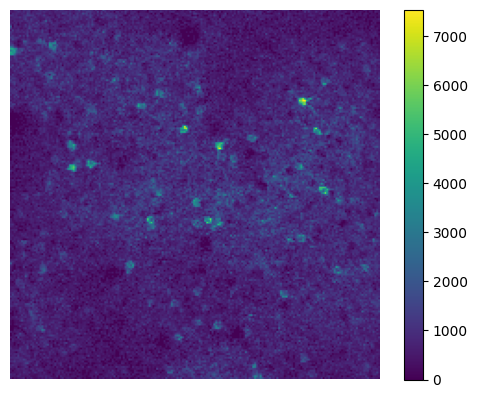

In [12]:
# show a decompressed frame
plt.imshow(z_reopened[10,:,:])
plt.axis(False)
plt.colorbar()

We compare compressed data with raw data to see if there is any structure in the difference

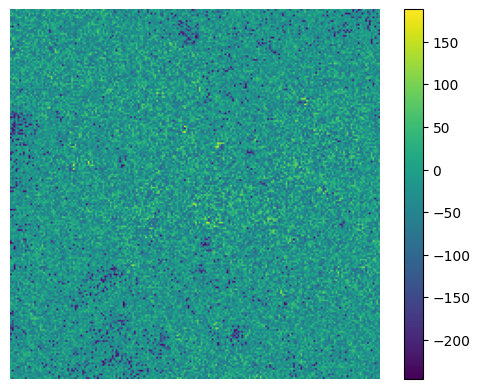

In [13]:
z_diff = z_reopened[:,:,:] - data[:,:,:]
plt.imshow(z_diff[10,:,:])
plt.axis(False)
plt.colorbar()

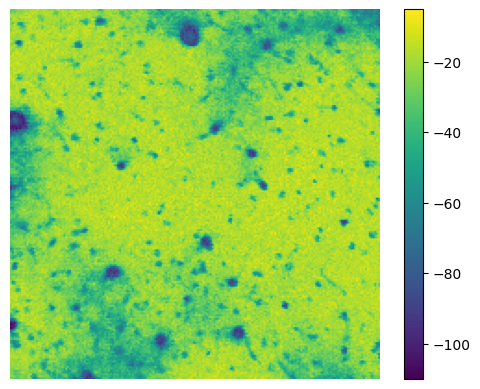

In [14]:
projection = np.mean(z_diff, axis=0)
plt.imshow(projection)
plt.axis(False)
plt.colorbar()

It is helpful to see all 3 movies in the same range. 

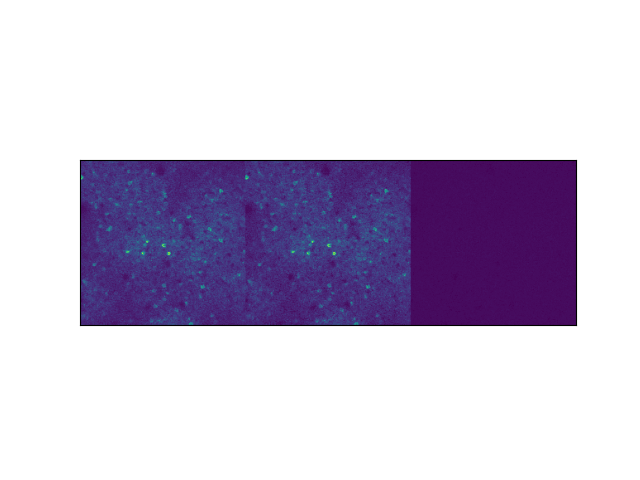

In [15]:
from mpl_interactions import hyperslicer

%matplotlib ipympl
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# We merge raw, reconstructed and difference images into a single array
# to compare them side by side
merged = np.concatenate([data, z_reopened[:,:,:], z_diff], axis=2)
view = hyperslicer(merged, play_buttons=True)